# Implement MatMul

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [6]:
#export
import operator

def test(a,b,cmp,cname=None):
    if cname is None: 
        cname=cmp.__name__
        
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): 
    test(a,b,operator.eq,'==')

In [7]:
#export 

from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [8]:
path = datasets.download_data(MNIST_URL, ext='.gz'); 
path

PosixPath('/home/john/.fastai/data/mnist.pkl.gz')

In [12]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid,y_valid), test_set) = pickle.load(f, encoding='latin-1')


In [13]:
x_train

array([[0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.]], dtype=float32)

In [21]:
#overwriting numpy arrays with tensor equivalents. 
x_train,y_train, x_valid, y_valid = map(tensor, 
                                        (x_train, y_train, x_valid,y_valid))
# n-> number of elements, c -> number of columns or pixels per image
n,c = x_train.shape 

# describe the output
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

/home/john/anaconda3/envs/fastaiv1/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [22]:
assert n==y_train.shape[0]==50000
test_eq(c, 28*28)
test_eq(y_train.min(), 0)
test_eq(y_train.max(), 9)

In [28]:
mpl.rcParams['image.cmap'] = 'gray'
img = x_train[0]
img.shape

torch.Size([784])

In [29]:
img.view(28,28).type()

'torch.FloatTensor'

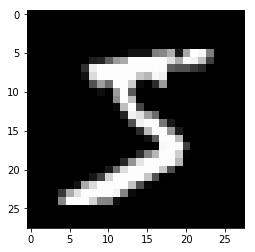

In [30]:
plt.imshow(img.view((28,28)))

# Creating simple model

In [34]:
weights = torch.randn(c,10)
bias = torch.zeros(10)
batch1 = x_train[:5, :]
batch1.shape

torch.Size([5, 784])

In [54]:
def mat_mul_1(a,b):
    result = torch.zeros(a.shape[0], b.shape[1])
    for i in range(a.shape[0]):
        for j in range(b.shape[1]):
            row = a[i,:]
            col = b[:,j]
            assert row.shape[0] == col.shape[0]
            sum_res = 0
            for k in range(row.shape[0]):
                sum_res += row[k]*col[k]
            result[i,j] = sum_res
    return result

In [62]:
#export
def near(a,b):
    return torch.allclose(a,b, rtol=1e-3, atol=1e-5)
def test_near(a,b):
    return test(a,b,near)

In [64]:

mul_res_1 = mat_mul_1(batch1, weights)
true_mul = batch1 @ weights
test_near(mul_res_1, true_mul)

In [65]:
%timeit -n 10 _=mat_mul_1(batch1, weights)

257 ms ± 3.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# now vectorize

In [69]:
def mat_mul_2(a,b):
    result = torch.zeros(a.shape[0], b.shape[1])
    for i in range(a.shape[0]):
        for j in range(b.shape[1]):
            row = a[i,:]
            col = b[:,j]
            assert row.shape[0] == col.shape[0]
            result[i,j] = (row*col).sum()
    return result

In [70]:
mul_res_2 = mat_mul_2(batch1, weights)
test_near(mul_res_2, true_mul)

In [72]:
%timeit -n 10 _=mat_mul_2(batch1, weights)

991 µs ± 24 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [101]:
def mat_mul_3(a,b):
    result = torch.zeros(a.shape[0], b.shape[1])
    for i in range(a.shape[0]):
        row = (a[i,:])[:, None] # broadcasting
        tmp = row*b
        result[i,:] = (tmp).sum(0)
    return result

In [102]:
mul_res_3 = mat_mul_3(batch1, weights)
test_near(mul_res_3, true_mul)

In [103]:
%timeit -n 10 _=mat_mul_3(batch1, weights)

209 µs ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [104]:
def mat_mul_4(a,b):
    return torch.einsum('ik,kj->ij', a, b)


In [105]:
mul_res_4 = mat_mul_4(batch1, weights)
test_near(mul_res_4, true_mul)

In [106]:
%timeit -n 10 _=mat_mul_4(batch1, weights)

93.6 µs ± 9.59 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [107]:
%timeit -n 10 _=batch1@weights

54.6 µs ± 6.46 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Export

In [110]:
!python notebook2script.py 01_MatMul.ipynb

Converted 01_MatMul.ipynb to exp/nb_01.py
